In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import sys

# データの確認
## データのロード

In [5]:
df = pd.read_csv("x.csv",header = None) #データをロードしました。
print("データのshape : ",df.shape) #(10000, 3)
df.head()

データのshape :  (10000, 3)


,0,1,2
0,-0.772081,3.30056,-2.14486
1,-1.543720,1.91863,-7.25592
2,6.615610,-1.37613,6.91670
3,-5.519160,2.18445,-2.91299
4,4.744200,-1.61953,4.61999


## 可視化
以下を見る限り、３つのクラスに分割するのが理想に見える・・・

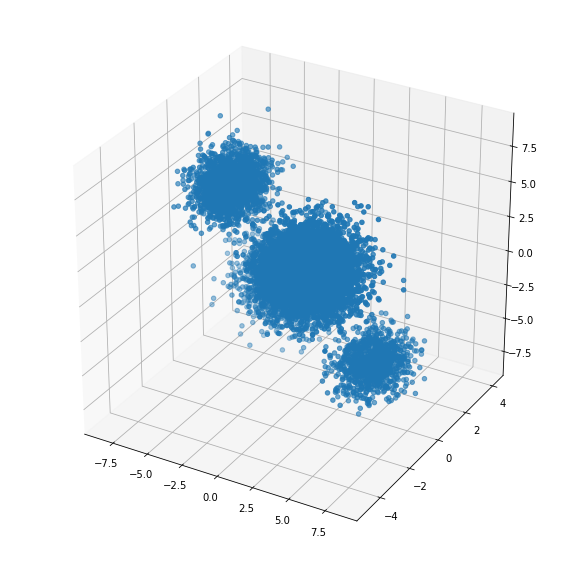

In [33]:
#以下でプロットしています。
rcParams['figure.figsize'] = 10,10
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection="3d")
x = df.values
ax.scatter3D(x.T[0],x.T[1],x.T[2])
plt.show()

# 実装

## EMアルゴリズム
今回はGMMを用いてのEMアルゴリズムを実装した。<br>

In [228]:
class EM:
    def __init__(self,data):
        self.data = data
    def fit(self,step,param_init):
        self.c = len(param_init)
        if step >= 1:
            self.step = step
        else:
            print("ステップ数は１以上にしてください", file=sys.stderr)
            sys.exit(1)
        self.param = param_init.copy()
        print("param_init", self.param)
        self.Estep()
    def Estep(self):
        #今回のEステップは混合正規分布の混合比を更新します。
        self.p = [] #現在のパラメータを用いた確率
        for i,para in self.param.items():
            m = para["m"]
            v = para["v"]
            self.p.append(multivariate_normal.pdf(x,m,v))
        self.p = np.array(self.p)
        self.g = self.p/np.sum(self.p,axis=0) #ガンマに対応。各データがどの潜在変数に対応するかを示す確率
        self.Mstep()
    def out2(self,x):
        return np.outer(x,x)
    def Mstep(self):
        for c in range(self.c):
            self.param[c]["pi"] = np.sum(self.g[c])/np.sum(self.g)
            self.param[c]["m"] = np.sum((x.T*self.g[c]).T,
                                        axis=0)/np.sum(self.g[c])
            m = self.param[c]["m"]
            self.param[c]["v"] = (np.sum((np.apply_along_axis(self.out2,1,x).T*self.g[c]).T,axis=0).T
                                  /np.sum(self.g[c])).T - np.outer(m,m)
        print("==============================================================")
        print(self.param)
        self.step = self.step - 1
        if self.step <= 0:
            pass
        else:
            self.Estep()

### 実行結果
今回実装したclass EMは、インスタンス宣言時に引数として、以下を要求する。<br>
・data : 学習に用いるデータ<br>
・step : 学習を行うステップ数<br>
・param_init : <br>

In [229]:
em = EM(data = x)
param_i = {}
for i in range(3):
    A = np.random.uniform(-5, 6, (3)) #ランダムな行列を平均の初期値として使う
    B = np.random.uniform(-5, 6, (3,3))
    spd = B.dot(B.T) #ランダムな正定値対称行列を分散の初期値として使う
    param_i[i]={"pi" : 1/3,
              "m" : A,
              "v" : spd }
em.fit(step = 10,param_init = param_i)
print(em.param)

param_init {0: {'pi': 0.3333333333333333, 'm': array([-4.61599655,  3.58737117,  5.49432135]), 'v': array([[ 78.32289931,  64.94017731, -17.24768174],
       [ 64.94017731,  56.8911545 , -11.7500965 ],
       [-17.24768174, -11.7500965 ,  26.74690994]])}, 1: {'pi': 0.3333333333333333, 'm': array([-1.51126414, -3.90554087,  1.2563832 ]), 'v': array([[16.14993884,  6.83569223, 12.94220258],
       [ 6.83569223, 25.92384894,  2.4762115 ],
       [12.94220258,  2.4762115 , 19.8690927 ]])}, 2: {'pi': 0.3333333333333333, 'm': array([-1.27185483, -2.04421043,  2.89428533]), 'v': array([[ 21.34454113, -14.14411956,   1.14878389],
       [-14.14411956,  37.22818987, -26.85395071],
       [  1.14878389, -26.85395071,  24.6333757 ]])}}
{0: {'pi': 0.19434976532873988, 'm': array([-4.63810559,  1.01212202,  2.02394084]), 'v': array([[ 1.62621024,  0.7870705 , -3.10511654],
       [ 0.7870705 ,  1.35567775, -4.00521006],
       [-3.10511654, -4.00521006, 17.83496111]])}, 1: {'pi': 0.6680083867286948

In [230]:
def plot_EM(x,param):
    rcParams['figure.figsize'] = 10,10
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection="3d")
    color = np.array([multivariate_normal.pdf(x,param[i]["m"],param[i]["v"]) for i in range(len(param))]).T
    color = (color.T/np.linalg.norm(color,axis=1)).T
    #color_list.append(color)
    ax.scatter3D(x.T[0],x.T[1],x.T[2],color = color)
    plt.show() 

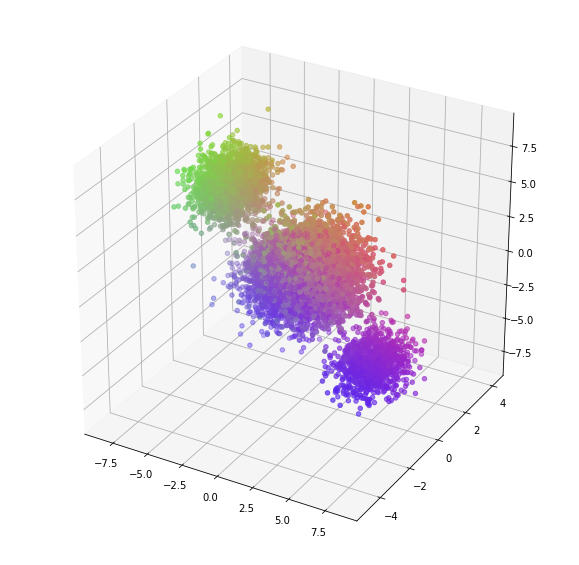

In [231]:
plot_EM(x,par)

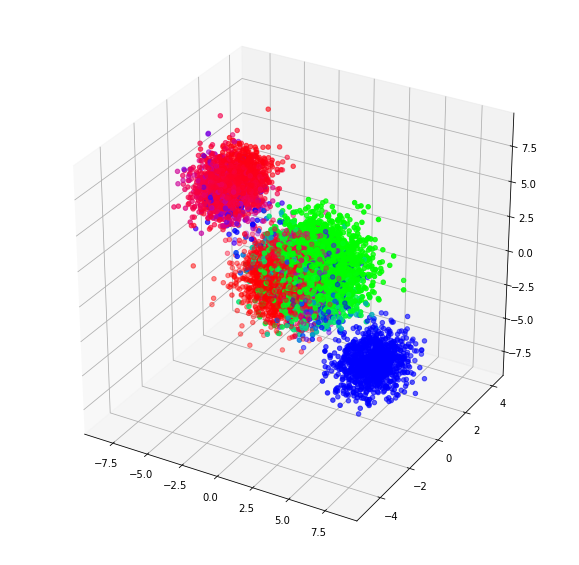

In [232]:
plot_EM(x,em.param)

## 変分ベイズ

In [157]:
class VB:
    def __init__(self,data,step):
        self.data = data
        if step >= 1:
            self.step = step
        else:
            print("ステップ数は１以上にしてください", file=sys.stderr)
            sys.exit(1)
    def fit(self):
        self.Estep(self.data,self.step)
    def Estep(self,data,step):
        self.Mstep(self.data,self.step)
    def Mstep(self,data,step):
        self.step = self.step - 1
        if self.step == 0:
            return 1
        else:
            self.Estep(self.data,self.step)

### 実行結果